In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (17, 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
AUDIO_DIR = '/content/drive/MyDrive/DataSets/DL/genres'

In [ ]:
get_genre = lambda filename : filename.split('.')[0]

def get_filenames(audio_dir):
    """
    Get the filenames of all the aduio files.
    :param audio_dir: Path to the directory where all the audio files are stored.
    :return: List of all the filenames.
    """
    filenames = []
    for _, dirs, files in os.walk(audio_dir, topdown=False):
        if dirs == []:
            for file in files:
                filenames.append(file)
    return filenames

def get_path(audio_dir, filename):
    """
    Get the path of the audio file of the given filename.
    :param audio_dir: Path to the directory where all the audio files are stored.
    :param filename: filename of the audio file we want the path to.
    :return: The path to the audio file.
    """
    # Adds back leading zeros for the track ID we want.
    folder = get_genre(filename)
    # The audio file is stored in folders with the leading three digits of the audio filename.
    return os.path.join(audio_dir, folder, filename)

In [ ]:
# Test functions work properly
filenames = get_filenames(AUDIO_DIR)
filenames.sort()
assert len(filenames) == 1000
assert get_path(AUDIO_DIR, filenames[0]) == '/content/drive/MyDrive/DataSets/DL/genres/blues/blues.00000.wav'

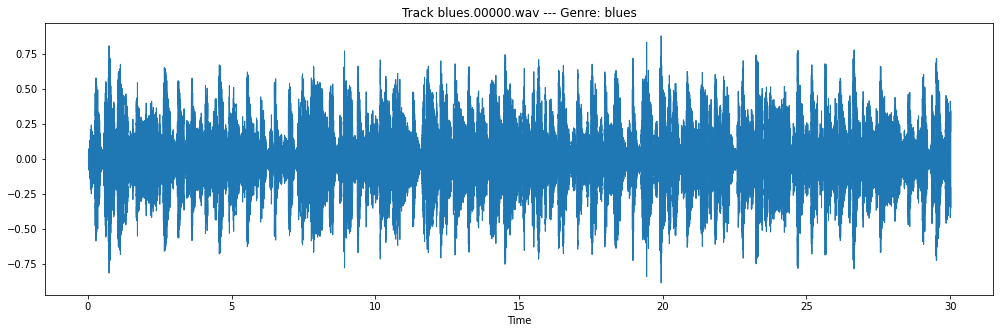

In [ ]:
import librosa.display
filename = filenames[0]
filepath = get_path(AUDIO_DIR, filename)
genre = filename.split('.')[0]
y, sr = librosa.load(filepath)
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title('Track {} --- Genre: {}'.format(filename, genre))
plt.show()

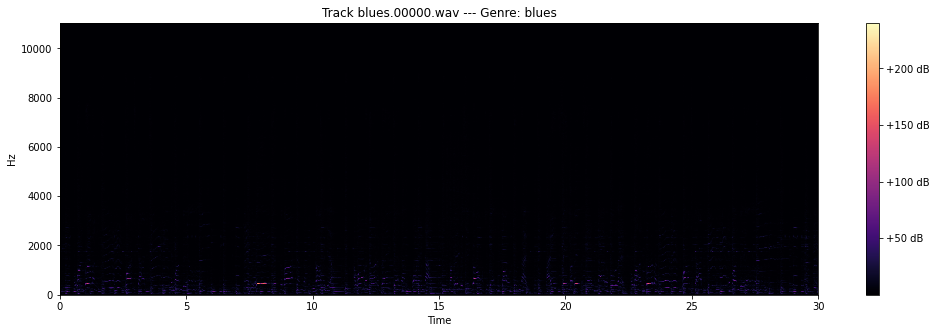

In [ ]:
D = np.abs(librosa.stft(y))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.title('Track {} --- Genre: {}'.format(filename, genre))
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
SR = 22050
HOP_LENGTH = 1024
N_FFT = 2048
N_MELS = 128

def log_melspectrogram(filename, *, plot=False, genre_label=''):
    """
    Generate the log melspectrogram using an audio time series. Optionally this function will
    also plot the log melspectrogram.
    :param tid: Track ID of the audio file.
    :param plot: Bool value, when true the log melspectrogram generated will be plotted. 
                 By default this kwarg is set to false.
    :param genre_label: Genre label assosiated with the track.
    :return: The log melspectrogram
    """
    filepath = get_path(AUDIO_DIR, filename)
    
    y, _ = librosa.load(filepath)
    
    melspec = librosa.feature.melspectrogram(y=y, sr=SR, hop_length=HOP_LENGTH, n_fft=N_FFT, n_mels=N_MELS)

    melspec = librosa.power_to_db(melspec, ref=np.max)

    if plot:
            
        if genre_label != '':
            
            plt.title('Track {} --- Genre: {}'.format(filename, genre_label))
            
        else:
            
            plt.title('Track {}'.format(filename))
            
        librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.show()

    return melspec

In [ ]:
def batch_create_log_melspectrograms(filenames):
    """
    Generate the log melspectrograms for all the tracks in the given pandas dataframe.
    :param df: Pandas dataframe containing the tracks to convert to log melspectrograms.
    :return: The array of log melspectrograms for all the tracks in the given dataframe and their genres.
    """
    melspecs = np.empty((0, 128, 640))
    genres = []
    
    for i, filename in enumerate(filenames):

        # Generate the log melspectrogram
        melspec = log_melspectrogram(filename)

        # Not all of the melspecs have the same dimensions, therefore, I decided to cut off 
        # anything after 640. This is just the time frame, so lossing some data here in the las couple ms.
        melspec = melspec[:,:640]

        # So in my experience np.concatenate is much faster than append.
        # Therefore we append the first element and then concatenate after for the 
        # rest of the elements.
        if i == 0:
            melspecs = np.append(melspecs, [melspec], axis=0)
        else:
            melspecs = np.concatenate((melspecs, [melspec]), axis=0)

        # Save genre
        genre = get_genre(filename)
        genres.append(genre)

        # Progress update
        if (i+1) % 100 == 0:
            print('Finished {} tracks'.format(i+1))
            
    melspecs = np.array(melspecs)
    labels = np.array(genres)
    
    return melspecs, labels

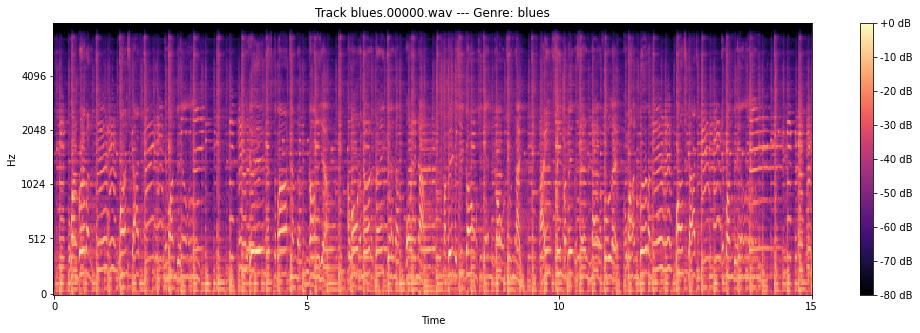

In [ ]:
filename = filenames[0]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

In [ ]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
melspecs, labels = batch_create_log_melspectrograms(filenames)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks
Finished 900 tracks
Finished 1000 tracks


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(melspecs, labels, shuffle=True, test_size=0.1)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
for (u, c) in zip(unique, counts):
    print('{} : {}'.format(u, c))

blues : 91
classical : 93
country : 91
disco : 88
hiphop : 94
jazz : 92
metal : 90
pop : 85
reggae : 88
rock : 88


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
le.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [ ]:
label_train = le.transform(y_train)
label_test = le.transform(y_test)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [ ]:
np.savez('/content/drive/MyDrive/DataSets/DL/melspects_128.npz', X_train=X_train, y_train=label_train, 
         X_test=X_test, y_test=label_test)

# KNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize'] = (15, 15)

In [ ]:
npzfile = np.load('/content/drive/MyDrive/DataSets/DL/melspects_128.npz', allow_pickle=True)

In [ ]:
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
pca = PCA(n_components=18)
pca.fit(X_train_sc)

X_train_reduced = pca.transform(X_train_sc)
X_test_reduced = pca.transform(X_test_sc)

In [ ]:
parameters = {'weights':('uniform', 'distance'), 'n_neighbors': range(5, 16)}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parameters)

In [ ]:
clf.fit(X_train_reduced, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 16),
                         'weights': ('uniform', 'distance')})

In [ ]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'n_neighbors': 6, 'weights': 'distance'}

Grid scores on development set:

0.463 (+/-0.021) for {'n_neighbors': 5, 'weights': 'uniform'}
0.480 (+/-0.033) for {'n_neighbors': 5, 'weights': 'distance'}
0.466 (+/-0.018) for {'n_neighbors': 6, 'weights': 'uniform'}
0.483 (+/-0.031) for {'n_neighbors': 6, 'weights': 'distance'}
0.466 (+/-0.034) for {'n_neighbors': 7, 'weights': 'uniform'}
0.478 (+/-0.034) for {'n_neighbors': 7, 'weights': 'distance'}
0.459 (+/-0.025) for {'n_neighbors': 8, 'weights': 'uniform'}
0.481 (+/-0.042) for {'n_neighbors': 8, 'weights': 'distance'}
0.459 (+/-0.040) for {'n_neighbors': 9, 'weights': 'uniform'}
0.473 (+/-0.044) for {'n_neighbors': 9, 'weights': 'distance'}
0.454 (+/-0.048) for {'n_neighbors': 10, 'weights': 'uniform'}
0.468 (+/-0.037) for {'n_neighbors': 10, 'weights': 'distance'}
0.476 (+/-0.073) for {'n_neighbors': 11, 'weights': 'uniform'}
0.478 (+/-0.079) for {'n_neighbors': 11, 'weights': 'distance'

In [ ]:
y_prob = clf.predict_proba(X_test_reduced)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro)".format(macro_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.823940 (macro)
One-vs-Rest ROC AUC scores:
0.824128 (macro)


# svc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize'] = (15, 15)

In [ ]:
parameters = {'C': np.arange(0.5, 3.0, 0.1)}

svc = SVC(kernel='rbf')

clf = GridSearchCV(svc, parameters)

In [ ]:
clf.fit(X_train_reduced, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9])})

In [ ]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 2.6999999999999993}

Grid scores on development set:

0.483 (+/-0.051) for {'C': 0.5}
0.488 (+/-0.049) for {'C': 0.6}
0.494 (+/-0.046) for {'C': 0.7}
0.501 (+/-0.056) for {'C': 0.7999999999999999}
0.510 (+/-0.051) for {'C': 0.8999999999999999}
0.516 (+/-0.052) for {'C': 0.9999999999999999}
0.519 (+/-0.050) for {'C': 1.0999999999999999}
0.521 (+/-0.037) for {'C': 1.1999999999999997}
0.522 (+/-0.040) for {'C': 1.2999999999999998}
0.521 (+/-0.044) for {'C': 1.4}
0.528 (+/-0.044) for {'C': 1.4999999999999998}
0.531 (+/-0.033) for {'C': 1.5999999999999996}
0.532 (+/-0.039) for {'C': 1.6999999999999997}
0.531 (+/-0.045) for {'C': 1.7999999999999998}
0.532 (+/-0.046) for {'C': 1.8999999999999997}
0.532 (+/-0.039) for {'C': 1.9999999999999996}
0.533 (+/-0.034) for {'C': 2.0999999999999996}
0.534 (+/-0.028) for {'C': 2.1999999999999997}
0.530 (+/-0.036) for {'C': 2.3}
0.527 (+/-0.035) for {'C': 2.3999999999999995}
0.530 (+/-0.038) for {'C': 2

In [ ]:
svc = SVC(kernel='rbf', probability=True, C=2.2)
svc.fit(X_train_reduced, y_train)

SVC(C=2.2, probability=True)

In [ ]:
y_prob = svc.predict_proba(X_test_reduced)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro)".format(macro_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.899599 (macro)
One-vs-Rest ROC AUC scores:
0.898653 (macro)


# PRCNN

In [ ]:
import numpy as np

import keras
from keras.models import Model
from keras.layers import Input, Dense, Bidirectional, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Lambda
from keras import backend as K

from keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report

In [ ]:
npzfile = np.load('/content/drive/MyDrive/DataSets/DL/melspects_128.npz', allow_pickle=True)

In [ ]:
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

In [ ]:
def PRCNN(X_shape, nb_classes):
    
    # Input
    inputs = Input(shape=X_shape)
    
    # CNN Block
    conv1 = Conv2D(filters=16, kernel_size=(1,3), strides=1, padding='valid', 
                   activation='relu')(inputs)
    
    pool11 = MaxPooling2D((2, 2), strides=(2,2))(conv1)
    
    conv2 = Conv2D(filters=32, kernel_size=(1,3), strides=1, padding='valid', 
                   activation='relu')(pool11)
    
    pool12 = MaxPooling2D((2, 2), strides=(2,2))(conv2)
    
    conv3 = Conv2D(filters=64, kernel_size=(1,3), strides=1, padding='valid', 
                   activation='relu')(pool12)
    
    pool13 = MaxPooling2D((2, 2), strides=(2,2))(conv3)
    
    conv4 = Conv2D(filters=128, kernel_size=(1,3), strides=1, padding='valid', 
                   activation='relu')(pool13)
    
    pool14 = MaxPooling2D((4, 4), strides=(4,4))(conv4)
    
    conv5 = Conv2D(filters=64, kernel_size=(1,3), strides=1, padding='valid', 
                   activation='relu')(pool14)
    
    pool15 = MaxPooling2D((4, 4), strides=(4,4))(conv5)

    flatten1 = Flatten()(pool15)
    
    # BGRU-RNN block
    pool21 = MaxPooling2D((1,2), strides=(1,2))(inputs)
    
    # Remove channel axis so we can pass into Bidirectional GRU layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis=-1))(pool21)
    
    # Bidirectional GRU
    bigru_rnn = Bidirectional(GRU(128), merge_mode='concat')(squeezed)
    
    # Concat Output
    concat = concatenate([flatten1, bigru_rnn])
    
    # Softmax Output
    output = Dense(nb_classes, activation='softmax')(concat)
    
    model_output = output
    model = Model(inputs=inputs, outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
nb_classes = len(np.unique(y_train))
nb_epochs = 25
batch_size = 4

# Convert to one hot encoding
y_train_one_hot = np.zeros((y_train.size, nb_classes))
y_train_one_hot[range(y_train.size),y_train] = 1

# Need to add a channel dim for the convolution layers
X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

X_shape = X_train_expanded.shape[1:]

model = PRCNN(X_shape, nb_classes)

# Fit data to model
history = model.fit(X_train_expanded, y_train_one_hot, batch_size=batch_size, 
                    epochs=nb_epochs, validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 638, 16  64          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 319, 16)  0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
preds = model.predict(X_test_expanded)
y_pred = np.argmax(preds, axis=1)

4/4 [==============================] - 3s 353ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.86      0.86      0.86         7
           2       0.33      0.22      0.27         9
           3       0.38      0.42      0.40        12
           4       0.08      0.17      0.11         6
           5       0.57      0.50      0.53         8
           6       0.25      0.80      0.38        10
           7       0.50      0.13      0.21        15
           8       0.60      0.50      0.55        12
           9       0.00      0.00      0.00        12

    accuracy                           0.37       100
   macro avg       0.42      0.39      0.37       100
weighted avg       0.41      0.37      0.35       100



# CNN

In [ ]:
import numpy as np

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import optimizers

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
npzfile = np.load('/content/drive/MyDrive/DataSets/DL/melspects_128.npz', allow_pickle=True)

In [ ]:
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

In [ ]:
def CNN(X_shape, nb_classes):
    
    # Input
    inputs = Input(shape=X_shape)
    
    conv1 = Conv2D(filters=32, kernel_size=(2,2), strides=1, padding='valid', 
                   activation='relu')(inputs)
    
    b1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(b1)
    
    conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', 
                   activation='relu')(pool1)
    
    pool2 = MaxPooling2D((3, 3), strides=(3, 3))(conv2)
    
    dr1 = Dropout(0.2)(pool2)
    
    conv3 = Conv2D(filters=64, kernel_size=(2,2), strides=1, padding='valid', 
                   activation='relu')(dr1)
    
    b2 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling2D((2, 2), strides=(2, 4))(b2)

    dr2 = Dropout(0.2)(pool3)
    
    flatten = Flatten()(dr2)
    
    dense1 = Dense(64, activation='relu')(flatten)
    
    dense2 = Dense(32, activation='relu')(dense1)
    
    # Softmax Output
    output = Dense(nb_classes, activation='softmax')(dense2)
    
    model_output = output
    model = Model(inputs=inputs, outputs=[output])
    
    opt = optimizers.Adagrad(learning_rate=0.001)
    model.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
nb_classes = len(np.unique(y_train))
nb_epochs = 75
batch_size = 2

# Convert to one hot encoding
y_train_one_hot = np.zeros((y_train.size, nb_classes))
y_train_one_hot[range(y_train.size),y_train] = 1

# Need to add a channel dim for the convolution layers
X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

X_shape = X_train_expanded.shape[1:]

model = CNN(X_shape, nb_classes)

# Fit data to model
history = model.fit(X_train_expanded, y_train_one_hot, batch_size=batch_size, 
                    epochs=nb_epochs, validation_split=0.2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 640, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 127, 639, 32)      160       
                                                                 
 batch_normalization (BatchN  (None, 127, 639, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 319, 32)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 317, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 105, 64)      0   

In [ ]:
preds = model.predict(X_test_expanded)
y_pred = np.argmax(preds, axis=1)

4/4 [==============================] - 3s 572ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.56      0.71      0.63         7
           2       0.09      0.11      0.10         9
           3       0.62      0.42      0.50        12
           4       0.40      0.67      0.50         6
           5       0.86      0.75      0.80         8
           6       0.56      1.00      0.71        10
           7       0.60      0.20      0.30        15
           8       0.83      0.83      0.83        12
           9       0.33      0.42      0.37        12

    accuracy                           0.51       100
   macro avg       0.53      0.53      0.50       100
weighted avg       0.54      0.51      0.49       100

